# Oversampling

# Data Iris-full
Berikut langkah-langkah nya 

## Oversampling Menggunakan SMOTE  

### Impor Library dan Koneksi Database  
Pada langkah pertama ini, kita akan mengimpor semua library yang dibutuhkan untuk analisis, mulai dari koneksi database hingga visualisasi. Kredensial database dimuat secara aman dari file .env untuk menghindari menuliskannya langsung di dalam kode.

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables
load_dotenv()

# PostgreSQL credentials
user_postgres = os.getenv("USER_POSTGRES")
password_postgres = os.getenv("PASS_POSTGRES")
host_postgres = os.getenv("HOST_POSTGRES")
port_postgres = os.getenv("PORT_POSTGRES")
db_postgres = os.getenv("DB_POSTGRES")

# MySQL credentials
user_mysql = os.getenv("USER_MYSQL")
password_mysql = os.getenv("PASS_MYSQL")
host_mysql = os.getenv("HOST_MYSQL")
port_mysql = os.getenv("PORT_MYSQL")
db_mysql = os.getenv("DB_MYSQL")

# Connections
postgres_conn = f"postgresql+psycopg2://{user_postgres}:{password_postgres}@{host_postgres}:{port_postgres}/{db_postgres}"
mysql_conn = f"mysql+pymysql://{user_mysql}:{password_mysql}@{host_mysql}:{port_mysql}/{db_mysql}"

postgres_engine = create_engine(postgres_conn)
mysql_engine = create_engine(mysql_conn)

ModuleNotFoundError: No module named 'pandas'

### Mengambil Data dari Database  
Setelah koneksi berhasil dibuat, kita akan mengambil data dari tabel iris_coba pada masing-masing database (MySQL dan PostgreSQL) dan memuatnya ke dalam DataFrame pandas.

In [26]:
mysql_df_iris = pd.read_sql("SELECT * FROM iris_coba", mysql_engine.connect())
postgres_df_iris = pd.read_sql("SELECT * FROM iris_coba", postgres_engine.connect())


### Visualisasi Data Awal (Sebelum SMOTE)  
Sebelum melakukan penyeimbangan, penting untuk memahami kondisi awal data. Di sini, saya akan memvisualisasikan data menggunakan PCA dan LDA untuk melihat sebaran kelasnya. 

Kolom dataset: Index(['id', 'Class', 'sepal length', 'sepal width', 'petal length',
       'petal width'],
      dtype='object')


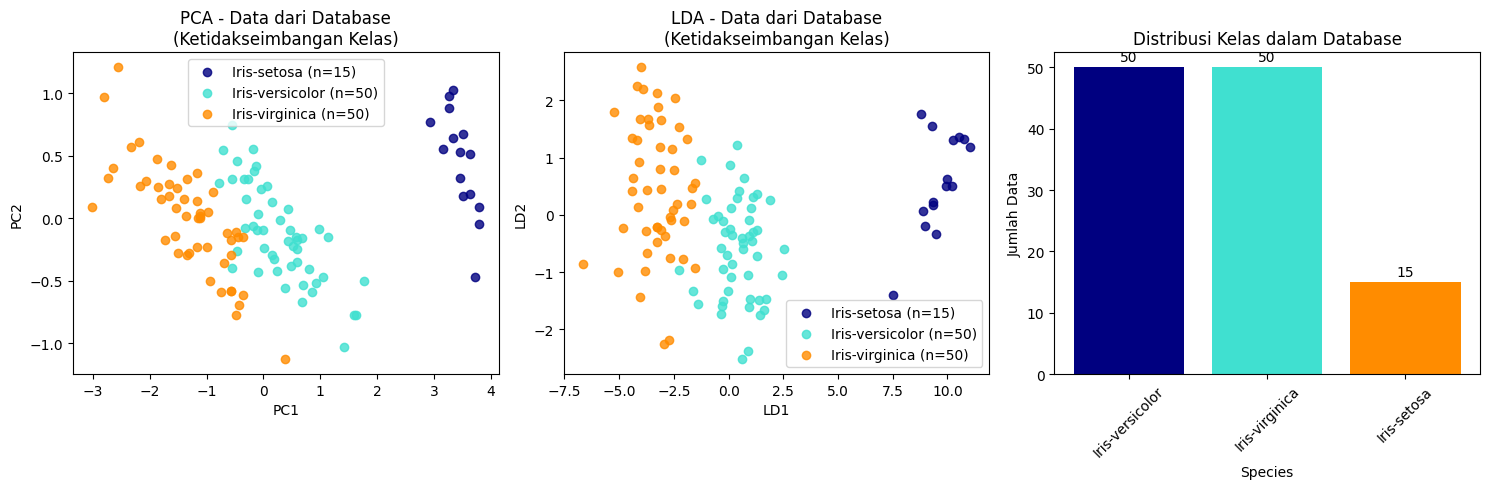


Explained variance ratio (database): [0.8962252 0.0647599]


In [27]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# --- Gunakan dataframe dari database kamu ---
df = mysql_df_iris   # bisa juga ganti ke postgres_df_iris

# --- Cek nama kolom ---
print("Kolom dataset:", df.columns)

# --- Ambil fitur dan target ---
X_db = df[['sepal length', 'sepal width', 'petal length', 'petal width']].values
y_db = df['Class'].values   # target ada di kolom 'Class'

# --- Mapping label ke angka ---
species_mapping = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
y_numeric = np.array([species_mapping[s] for s in y_db])
target_names_db = list(species_mapping.keys())

# --- PCA (2 dimensi) ---
pca_db = PCA(n_components=2)
X_r_db = pca_db.fit(X_db).transform(X_db)

# --- LDA (2 dimensi) ---
lda_db = LinearDiscriminantAnalysis(n_components=2)
X_r2_db = lda_db.fit(X_db, y_numeric).transform(X_db)

# === Visualisasi ===
plt.figure(figsize=(15, 5))

# ---- Plot PCA ----
plt.subplot(1, 3, 1)
colors = ["navy", "turquoise", "darkorange"]
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r_db[mask, 0], X_r_db[mask, 1],
                color=color, alpha=0.8,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA - Data dari Database\n(Ketidakseimbangan Kelas)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# ---- Plot LDA ----
plt.subplot(1, 3, 2)
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r2_db[mask, 0], X_r2_db[mask, 1],
                color=color, alpha=0.8,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA - Data dari Database\n(Ketidakseimbangan Kelas)")
plt.xlabel("LD1")
plt.ylabel("LD2")

# ---- Plot distribusi kelas ----
plt.subplot(1, 3, 3)
species_counts = df['Class'].value_counts()
plt.bar(species_counts.index, species_counts.values,
        color=['navy', 'turquoise', 'darkorange'])
plt.title("Distribusi Kelas dalam Database")
plt.xlabel("Species")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
for i, v in enumerate(species_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nExplained variance ratio (database): {pca_db.explained_variance_ratio_}")


### Visualisasi Perbandingan Hasil SMOTE

Ini adalah langkah akhir untuk memverifikasi hasil. Kita akan membuat visualisasi perbandingan *side-by-side* menggunakan PCA untuk menunjukkan perbedaan sebaran data sebelum dan sesudah penerapan SMOTE, sekaligus membuktikan bahwa data kini telah seimbang.

In [28]:
# Ambil DataFrame dari langkah sebelumnya
df = mysql_df_iris

# Pilih HANYA kolom fitur yang relevan, buang 'id' dan 'Class'
X_features = df[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_target = df['Class']

# Mapping label string ke angka untuk model
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y_numeric = np.array([species_mapping[s] for s in y_target])

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Menerapkan SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(Counter(y_numeric))

# Inisialisasi SMOTE dengan random_state untuk hasil yang konsisten
smote = SMOTE(random_state=42)

# PENYESUAIAN: Menggunakan variabel X_features dan y_numeric yang sudah disiapkan
X_res, y_res = smote.fit_resample(X_features, y_numeric)

print("\nDistribusi kelas setelah SMOTE:")
print(Counter(y_res))
print(f"Total sampel setelah SMOTE: {len(y_res)}")



# 2. Membuat DataFrame Baru dari Hasil SMOTE

# Gabungkan fitur dan target yang sudah diseimbangkan
df_resampled = pd.DataFrame(X_res, columns=X_features.columns)

# PENYESUAIAN: Mapping kembali label numerik (0,1,2) ke nama kelas (string) untuk keterbacaan
# Buat mapping terbalik dari species_mapping sebelumnya
inv_species_mapping = {v: k for k, v in species_mapping.items()}
df_resampled['Class'] = pd.Series(y_res).map(inv_species_mapping)


print("\nContoh data sintetis yang dihasilkan SMOTE:")
# Tampilkan 10 baris terakhir, yang kemungkinan besar adalah data baru
print(df_resampled.tail(10))

Distribusi kelas sebelum SMOTE:
Counter({1: 50, 2: 50, 0: 15})

Distribusi kelas setelah SMOTE:
Counter({0: 50, 1: 50, 2: 50})
Total sampel setelah SMOTE: 150

Contoh data sintetis yang dihasilkan SMOTE:
     sepal length  sepal width  petal length  petal width        Class
140      4.965308     3.197962      1.500000     0.132654  Iris-setosa
141      4.485911     3.085911      1.342956     0.200000  Iris-setosa
142      4.495833     3.095833      1.347917     0.200000  Iris-setosa
143      5.003883     3.511648      1.611648     0.592234  Iris-setosa
144      4.431093     3.031093      1.315547     0.200000  Iris-setosa
145      4.874732     3.074732      1.474732     0.150536  Iris-setosa
146      4.584123     3.000000      1.346031     0.246031  Iris-setosa
147      4.776025     3.141325      1.458675     0.141325  Iris-setosa
148      4.903474     3.103474      1.489577     0.103474  Iris-setosa
149      4.860703     3.060703      1.460703     0.178593  Iris-setosa


### Visualisasi Perbandingan Distribusi Kelas  
Untuk membuktikan bahwa proses SMOTE berhasil, pada langkah ini kita membuat visualisasi perbandingan. Diagram batang di sebelah kiri menunjukkan distribusi kelas yang tidak seimbang (sebelum), sedangkan diagram di sebelah kanan menunjukkan bahwa semua kelas kini memiliki jumlah sampel yang sama (setelah). Tabel di bawahnya merangkum hasil ini secara numerik untuk memberikan bukti yang jelas.


=== VISUALISASI HASIL SMOTE ===


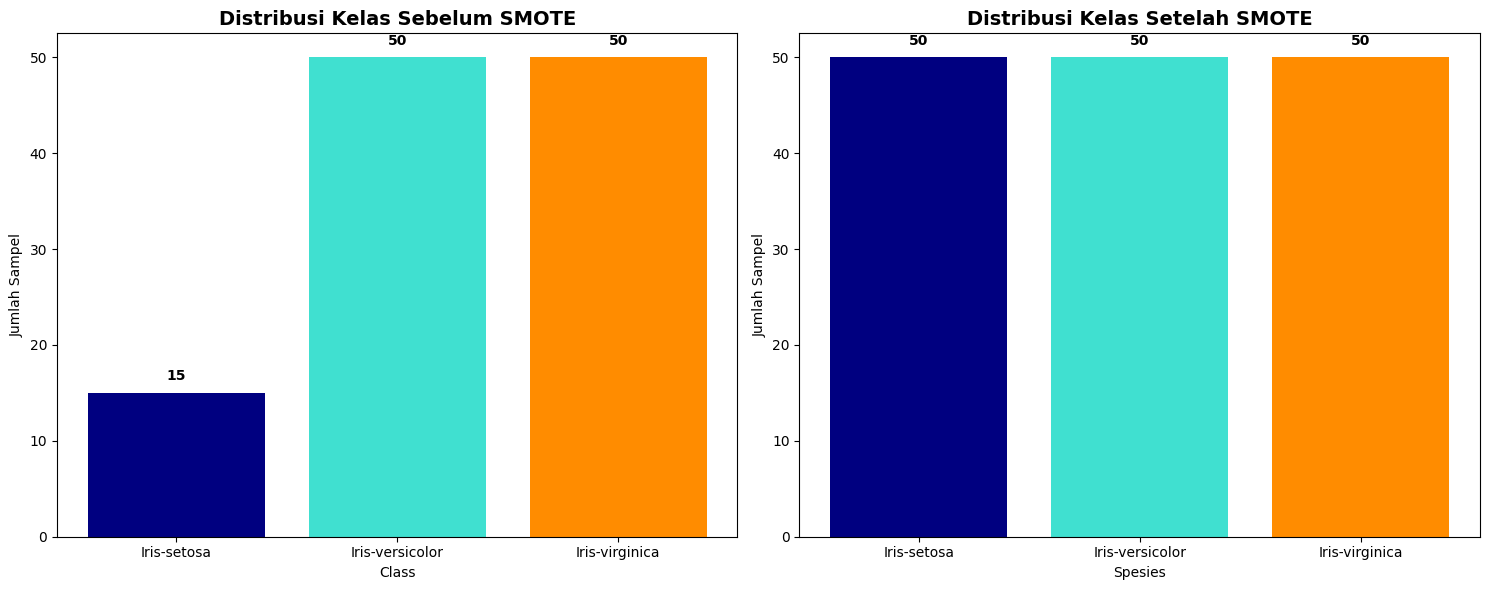


Tabel Perbandingan:
           Spesies  Sebelum SMOTE  Setelah SMOTE  Sampel Sintetis Ditambahkan
0      Iris-setosa             15             50                           35
1  Iris-versicolor             50             50                            0
2   Iris-virginica             50             50                            0


In [30]:
# Visualisasi perbandingan data sebelum dan sesudah SMOTE
print("\n=== VISUALISASI HASIL SMOTE ===")

# Buat subplot untuk perbandingan
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PERBAIKAN: Definisikan 'target_names' di sini agar variabel selalu tersedia.
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

# Plot distribusi kelas sebelum SMOTE
before_counts = Counter(y_numeric)
sorted_before_items = sorted(before_counts.items())
species_indices = [item[0] for item in sorted_before_items]
before_values = [item[1] for item in sorted_before_items]

bars1 = axes[0].bar(species_indices, before_values, color=['navy', 'turquoise', 'darkorange'])
axes[0].set_title('Distribusi Kelas Sebelum SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].set_xlabel('Class')
axes[0].set_xticks(species_indices)
axes[0].set_xticklabels(target_names) # Sekarang variabel ini sudah ada

# Tambahkan label nilai di atas bar
for bar, value in zip(bars1, before_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(value), ha='center', va='bottom', fontweight='bold')

# Plot distribusi kelas setelah SMOTE
after_counts = Counter(y_res)
sorted_after_items = sorted(after_counts.items())
after_values = [item[1] for item in sorted_after_items]

bars2 = axes[1].bar(species_indices, after_values, color=['navy', 'turquoise', 'darkorange'])
axes[1].set_title('Distribusi Kelas Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Jumlah Sampel')
axes[1].set_xlabel('Spesies')
axes[1].set_xticks(species_indices)
axes[1].set_xticklabels(target_names) # Sekarang variabel ini sudah ada

# Tambahkan label nilai di atas bar
for bar, value in zip(bars2, after_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Tabel perbandingan
print("\nTabel Perbandingan:")
comparison_df = pd.DataFrame({
    'Spesies': target_names,
    'Sebelum SMOTE': before_values,
    'Setelah SMOTE': after_values,
    'Sampel Sintetis Ditambahkan': [after_values[i] - before_values[i] for i in range(len(target_names))]
})
print(comparison_df)

### Penerapan SMOTE dan Visualisasi Perbandingan Hasil  
Ini adalah sel kode utama yang menjalankan keseluruhan proses. Pertama, kita mempersiapkan data dengan memilih hanya 4 kolom fitur yang relevan (membuang 'id'). Kemudian, kita menerapkan SMOTE untuk menyeimbangkan jumlah sampel di setiap kelas. Terakhir, kita menggunakan PCA untuk memvisualisasikan data dalam 2D, membandingkan kondisi sebelum dan sesudah SMOTE untuk membuktikan keberhasilan proses penyeimbangan.

Distribusi sebelum SMOTE: Counter({1: 50, 2: 50, 0: 15})
Distribusi setelah SMOTE: Counter({0: 50, 1: 50, 2: 50})




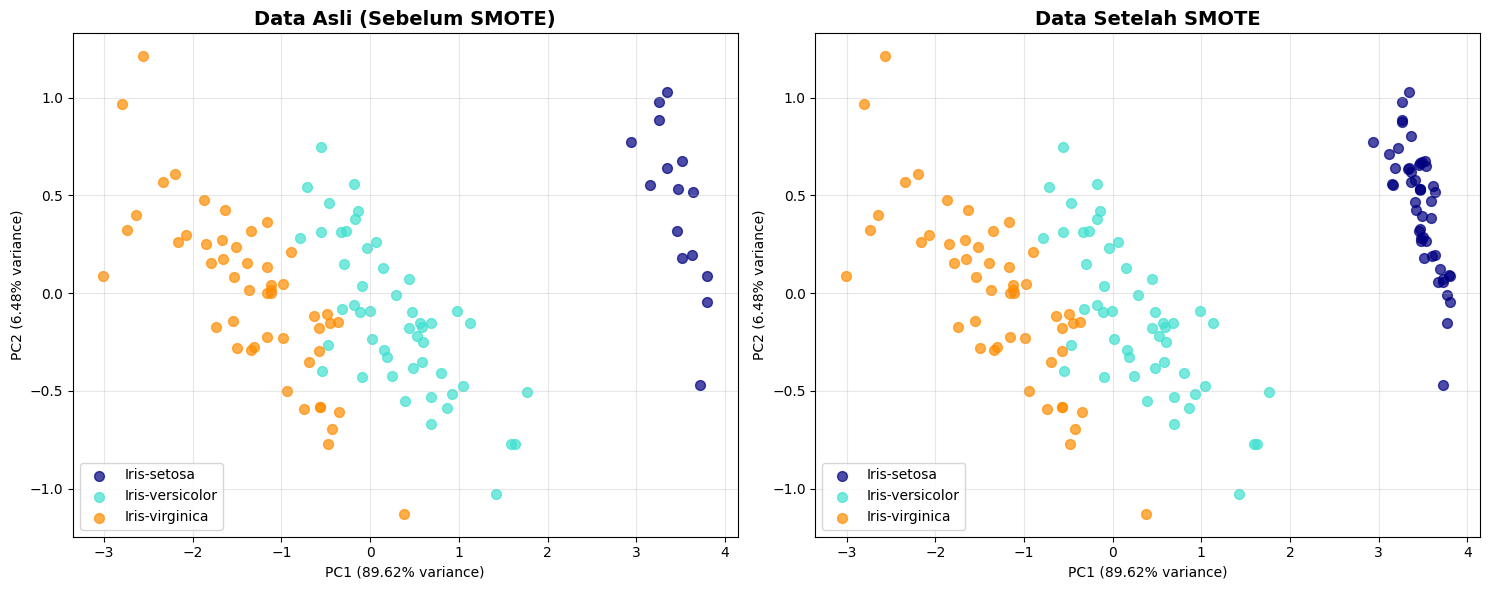

In [31]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# 1. PERBAIKAN: Persiapan Fitur dan Target yang Benar

# Ambil DataFrame dari langkah sebelumnya
df = mysql_df_iris

# Pilih HANYA kolom fitur yang relevan, buang 'id' dan 'Class'
X_features = df[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_target = df['Class']

# Mapping label string ke angka untuk model
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y_numeric = np.array([species_mapping[s] for s in y_target])
target_names = list(species_mapping.keys())


# 2. Terapkan SMOTE

print("Distribusi sebelum SMOTE:", Counter(y_numeric))

smote = SMOTE(random_state=42)
# Gunakan X_features (tanpa 'id') dan y_numeric untuk SMOTE
X_res, y_res = smote.fit_resample(X_features, y_numeric)

print("Distribusi setelah SMOTE:", Counter(y_res))
print("\n") # Memberi spasi sebelum plot


# 3. PCA untuk visualisasi 2D

pca = PCA(n_components=2)
# Latih PCA pada data fitur asli
X_pca_before = pca.fit_transform(X_features)
# Gunakan PCA yang sama untuk mentransformasi data setelah SMOTE
X_pca_after = pca.transform(X_res)


# 4. Visualisasi Perbandingan

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ['navy', 'turquoise', 'darkorange']

# --- Plot data asli (sebelum SMOTE) ---
for i, (color, label) in enumerate(zip(colors, target_names)):
    mask = y_numeric == i
    axes[0].scatter(X_pca_before[mask, 0], X_pca_before[mask, 1], c=color, label=label, alpha=0.7, s=50)
axes[0].set_title('Data Asli (Sebelum SMOTE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Plot data setelah SMOTE ---
for i, (color, label) in enumerate(zip(colors, target_names)):
    mask = y_res == i
    axes[1].scatter(X_pca_after[mask, 0], X_pca_after[mask, 1], c=color, label=label, alpha=0.7, s=50)
axes[1].set_title('Data Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Langkah Klasifikasi dengan SVM & Naive Bayes

### Cell 1 – Import Library

In [32]:
# Import library utama
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Metode klasifikasi
from sklearn.svm import SVC                   # SVM
from sklearn.naive_bayes import GaussianNB    # Naive Bayes

# Untuk balancing data
from imblearn.over_sampling import SMOTE
from collections import Counter


### Siapkan Data

In [33]:
# Gunakan dataframe dari database (contoh dari MySQL)
df = mysql_df_iris.copy()

# Fitur dan target
X = df[['sepal length', 'sepal width', 'petal length', 'petal width']]
y = df['Class']

# Mapping class string -> angka
species_mapping = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
y_num = y.map(species_mapping)

print("Jumlah data awal:", len(df))
print("Distribusi kelas awal:", Counter(y_num))


Jumlah data awal: 115
Distribusi kelas awal: Counter({1: 50, 2: 50, 0: 15})


### Split Data (Sebelum SMOTE)

In [34]:
# Bagi data training & testing (70:30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_num, test_size=0.3, random_state=42, stratify=y_num
)

print("Jumlah data train:", len(X_train))
print("Jumlah data test :", len(X_test))


Jumlah data train: 80
Jumlah data test : 35


### Klasifikasi SVM (Sebelum SMOTE)

In [35]:
# === METODE SVM ===
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("=== HASIL KLASIFIKASI SVM (Sebelum SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


=== HASIL KLASIFIKASI SVM (Sebelum SMOTE) ===
Confusion Matrix:
 [[ 5  0  0]
 [ 0 15  0]
 [ 0  0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



### Klasifikasi Naive Bayes (Sebelum SMOTE)

In [36]:
# === METODE NAIVE BAYES ===
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

print("=== HASIL KLASIFIKASI NAIVE BAYES (Sebelum SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


=== HASIL KLASIFIKASI NAIVE BAYES (Sebelum SMOTE) ===
Confusion Matrix:
 [[ 5  0  0]
 [ 0 13  2]
 [ 0  1 14]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.93      0.87      0.90        15
           2       0.88      0.93      0.90        15

    accuracy                           0.91        35
   macro avg       0.93      0.93      0.93        35
weighted avg       0.92      0.91      0.91        35



### Terapkan SMOTE

In [37]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y_num)

print("Distribusi sebelum SMOTE:", Counter(y_num))
print("Distribusi sesudah SMOTE:", Counter(y_res))

# Split ulang data hasil SMOTE
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)


Distribusi sebelum SMOTE: Counter({1: 50, 2: 50, 0: 15})
Distribusi sesudah SMOTE: Counter({0: 50, 1: 50, 2: 50})


### Klasifikasi SVM (Sesudah SMOTE)

In [38]:
# === METODE SVM ===
svm_clf_res = SVC(kernel='linear', random_state=42)
svm_clf_res.fit(X_train_res, y_train_res)

y_pred_svm_res = svm_clf_res.predict(X_test_res)

print("=== HASIL KLASIFIKASI SVM (Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_svm_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_svm_res))


=== HASIL KLASIFIKASI SVM (Sesudah SMOTE) ===
Confusion Matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



### Klasifikasi Naive Bayes (Sesudah SMOTE)

In [39]:
# === METODE NAIVE BAYES ===
nb_clf_res = GaussianNB()
nb_clf_res.fit(X_train_res, y_train_res)

y_pred_nb_res = nb_clf_res.predict(X_test_res)

print("=== HASIL KLASIFIKASI NAIVE BAYES (Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_nb_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_nb_res))


=== HASIL KLASIFIKASI NAIVE BAYES (Sesudah SMOTE) ===
Confusion Matrix:
 [[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.88        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



### Buat Fungsi Ekstrak Skor

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_scores(y_true, y_pred, model_name, kondisi):
    return {
        "Model": model_name,
        "Kondisi": kondisi,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro"),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1-Score": f1_score(y_true, y_pred, average="macro")
    }


### Simpan Semua Hasil ke Tabel

In [41]:
results = []

# --- Sebelum SMOTE ---
results.append(get_scores(y_test, y_pred_svm, "SVM", "Sebelum SMOTE"))
results.append(get_scores(y_test, y_pred_nb, "Naive Bayes", "Sebelum SMOTE"))

# --- Sesudah SMOTE ---
results.append(get_scores(y_test_res, y_pred_svm_res, "SVM", "Sesudah SMOTE"))
results.append(get_scores(y_test_res, y_pred_nb_res, "Naive Bayes", "Sesudah SMOTE"))

# Buat DataFrame untuk perbandingan
df_results = pd.DataFrame(results)
df_results


,Model,Kondisi,Accuracy,Precision,Recall,F1-Score
0,SVM,Sebelum SMOTE,1.000000,1.000000,1.000000,1.000000
1,Naive Bayes,Sebelum SMOTE,0.914286,0.934524,0.933333,0.933259
2,SVM,Sesudah SMOTE,1.000000,1.000000,1.000000,1.000000
3,Naive Bayes,Sesudah SMOTE,0.911111,0.915535,0.911111,0.910714


## Bagging Classifier

### Import Library

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

### BaggingClassifier SVM (Sebelum SMOTE)

In [43]:
# === BAGGING dengan SVM (Sebelum SMOTE) ===

# Base estimator = SVM
bagging_svm = BaggingClassifier(
    estimator=SVC(kernel='linear'),  # pakai SVM linear sebagai base model
    n_estimators=10,                 # jumlah model dalam ensemble
    random_state=42
)

# Latih model
bagging_svm.fit(X_train, y_train)

# Prediksi
y_pred_bagging_svm = bagging_svm.predict(X_test)

print("=== HASIL KLASIFIKASI BAGGING (SVM, Sebelum SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bagging_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bagging_svm))


=== HASIL KLASIFIKASI BAGGING (SVM, Sebelum SMOTE) ===
Confusion Matrix:
 [[ 5  0  0]
 [ 0 14  1]
 [ 0  0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.97        35
   macro avg       0.98      0.98      0.98        35
weighted avg       0.97      0.97      0.97        35



### BaggingClassifier Naïve Bayes (Sebelum SMOTE)

In [44]:
# === BAGGING dengan Naive Bayes (Sebelum SMOTE) ===
bagging_nb = BaggingClassifier(
    estimator=GaussianNB(),   # base model = Naive Bayes
    n_estimators=10,          # jumlah model
    random_state=42
)

# Latih model dengan data train sebelum SMOTE
bagging_nb.fit(X_train, y_train)

# Prediksi
y_pred_bagging_nb = bagging_nb.predict(X_test)

print("=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sebelum SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bagging_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bagging_nb))


=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sebelum SMOTE) ===
Confusion Matrix:
 [[ 5  0  0]
 [ 0 13  2]
 [ 0  1 14]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.93      0.87      0.90        15
           2       0.88      0.93      0.90        15

    accuracy                           0.91        35
   macro avg       0.93      0.93      0.93        35
weighted avg       0.92      0.91      0.91        35



### BaggingClassifier SVM (Sesudah SMOTE)

In [45]:
# === BAGGING dengan SVM (Sesudah SMOTE) ===

bagging_svm_res = BaggingClassifier(
    estimator=SVC(kernel='linear'),
    n_estimators=10,
    random_state=42
)

# Latih model
bagging_svm_res.fit(X_train_res, y_train_res)

# Prediksi
y_pred_bagging_svm_res = bagging_svm_res.predict(X_test_res)

print("=== HASIL KLASIFIKASI BAGGING (SVM, Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_bagging_svm_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_bagging_svm_res))


=== HASIL KLASIFIKASI BAGGING (SVM, Sesudah SMOTE) ===
Confusion Matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



### BaggingClassifier Naïve Bayes (Sesudah SMOTE)

In [46]:
# === BAGGING dengan Naive Bayes (Sesudah SMOTE) ===
bagging_nb_res = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=10,
    random_state=42
)

# Latih model dengan data train sesudah SMOTE
bagging_nb_res.fit(X_train_res, y_train_res)

# Prediksi
y_pred_bagging_nb_res = bagging_nb_res.predict(X_test_res)

print("=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_bagging_nb_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_bagging_nb_res))


=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sesudah SMOTE) ===
Confusion Matrix:
 [[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.88        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



### Tabel perbandingan

In [47]:
# === TABEL PERBANDINGAN HASIL BAGGING CLASSIFIER ===

# Kumpulkan hasil evaluasi semua model
bagging_results = []

# --- Bagging Sebelum SMOTE ---
bagging_results.append(get_scores(y_test, y_pred_bagging_svm, "Bagging SVM", "Sebelum SMOTE"))
bagging_results.append(get_scores(y_test, y_pred_bagging_nb, "Bagging Naive Bayes", "Sebelum SMOTE"))

# --- Bagging Sesudah SMOTE ---
bagging_results.append(get_scores(y_test_res, y_pred_bagging_svm_res, "Bagging SVM", "Sesudah SMOTE"))
bagging_results.append(get_scores(y_test_res, y_pred_bagging_nb_res, "Bagging Naive Bayes", "Sesudah SMOTE"))

# Buat DataFrame hasil perbandingan
df_bagging_results = pd.DataFrame(bagging_results)

# Tampilkan hasil tabel
print("=== PERBANDINGAN HASIL BAGGING CLASSIFIER ===")
df_bagging_results


=== PERBANDINGAN HASIL BAGGING CLASSIFIER ===


,Model,Kondisi,Accuracy,Precision,Recall,F1-Score
0,Bagging SVM,Sebelum SMOTE,0.971429,0.979167,0.977778,0.977753
1,Bagging Naive Bayes,Sebelum SMOTE,0.914286,0.934524,0.933333,0.933259
2,Bagging SVM,Sesudah SMOTE,0.977778,0.979167,0.977778,0.977753
3,Bagging Naive Bayes,Sesudah SMOTE,0.911111,0.915535,0.911111,0.910714


### ================================================================

# Data Bank-full
Berikut langkah-langkah nya 

## Oversampling Menggunakan SMOTE  

### Mengambil Data dari Database  
Data diambil dari MySQL (mysql_df_bank). 
Kolom target adalah "y" (yes/no), kemudian diubah menjadi numerik (0 = no, 1 = yes).
Fitur kategorikal diubah menjadi numerik dengan one-hot encoding ("pd.get_dummies").

In [48]:
mysql_df_bank = pd.read_sql("SELECT * FROM bank_full", mysql_engine.connect())
postgres_df_bank = pd.read_sql("SELECT * FROM bank_full", postgres_engine.connect())

OperationalError: (pymysql.err.OperationalError) (2013, 'Lost connection to MySQL server during query ([WinError 10054] An existing connection was forcibly closed by the remote host)')
[SQL: SELECT * FROM bank_full]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

### Visualisasi Data Awal (Sebelum SMOTE) 
Distribusi kelas pada dataset "bank_full" tidak seimbang (mayoritas "no", minoritas "yes").
Untuk mengatasi ini digunakan SMOTE yang menghasilkan data sintetis pada kelas minoritas.

Kolom dataset: Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')


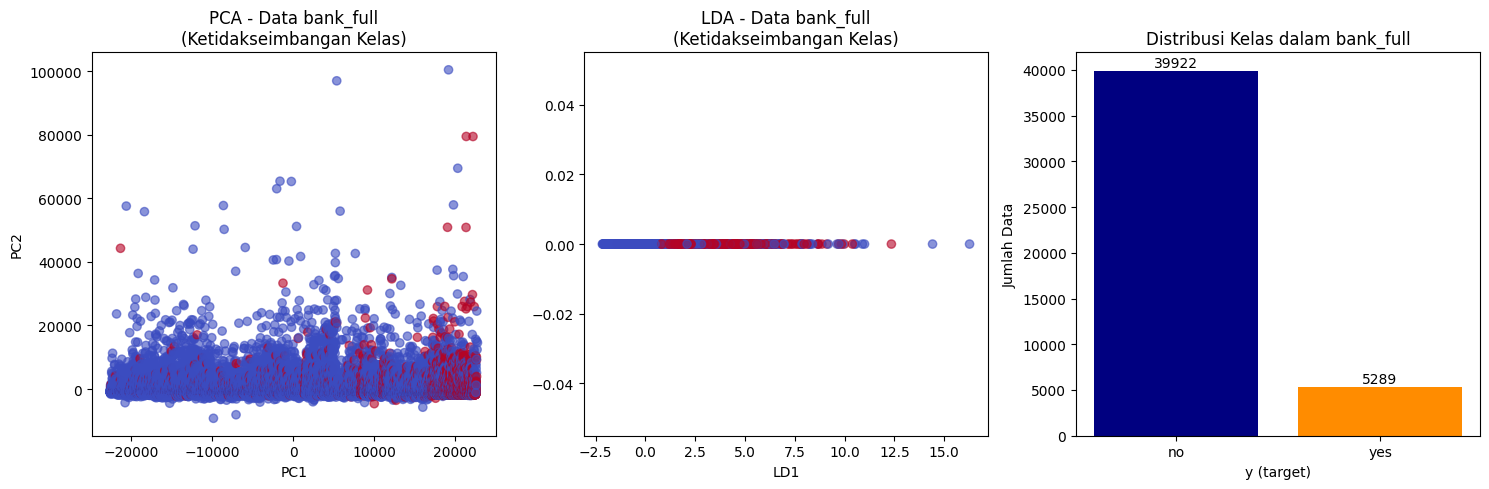


Explained variance ratio (database, PCA): [0.94828743 0.05129744]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- Gunakan dataframe dari database kamu ---
df = mysql_df_bank   # atau postgres_df_bank

# --- Cek nama kolom ---
print("Kolom dataset:", df.columns)

# --- Pisahkan fitur dan target ---
X_db = df.drop(columns=['y'])   # semua kolom kecuali target
y_db = df['y']                  # target yes/no

# --- Encoding fitur kategorikal ---
X_encoded = X_db.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# --- Ubah target ke angka ---
y_numeric = np.where(y_db == "yes", 1, 0)
target_names_db = ["no", "yes"]

# --- PCA (2 dimensi) ---
pca_db = PCA(n_components=2)
X_r_db = pca_db.fit(X_encoded).transform(X_encoded)

# --- LDA (2 dimensi) ---
lda_db = LinearDiscriminantAnalysis(n_components=1)  # binary target → cuma 1 komponen
X_r2_db = lda_db.fit(X_encoded, y_numeric).transform(X_encoded)

# === Visualisasi ===
plt.figure(figsize=(15, 5))

# ---- Plot PCA ----
plt.subplot(1, 3, 1)
plt.scatter(X_r_db[:, 0], X_r_db[:, 1],
            c=y_numeric, cmap=plt.cm.coolwarm, alpha=0.6)
plt.title("PCA - Data bank_full\n(Ketidakseimbangan Kelas)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# ---- Plot LDA ----
plt.subplot(1, 3, 2)
plt.scatter(X_r2_db[:, 0], np.zeros_like(X_r2_db),
            c=y_numeric, cmap=plt.cm.coolwarm, alpha=0.6)
plt.title("LDA - Data bank_full\n(Ketidakseimbangan Kelas)")
plt.xlabel("LD1")
plt.ylabel("")

# ---- Plot distribusi kelas ----
plt.subplot(1, 3, 3)
class_counts = df['y'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['navy', 'darkorange'])
plt.title("Distribusi Kelas dalam bank_full")
plt.xlabel("y (target)")
plt.ylabel("Jumlah Data")
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 100, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nExplained variance ratio (database, PCA): {pca_db.explained_variance_ratio_}")


### Visualisasi Perbandingan Hasil SMOTE
Data hasil one-hot encoding memiliki banyak fitur.
Untuk memudahkan visualisasi, digunakan PCA (Principal Component Analysis) menjadi 2 dimensi.
Hasil visualisasi ditampilkan untuk kondisi sebelum SMOTE dan sesudah SMOTE.

In [ ]:
# Ambil DataFrame dari langkah sebelumnya
df = mysql_df_bank   # atau postgres_df_bank

# Pilih semua kolom fitur kecuali target 'y'
X_features = df.drop(columns=['y'])

# Target adalah kolom 'y'
y_target = df['y']

# Encoding fitur kategorikal (karena banyak kolom object/string)
from sklearn.preprocessing import LabelEncoder
X_encoded = X_features.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Mapping target 'yes'/'no' ke angka
y_numeric = np.where(y_target == "yes", 1, 0)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Menerapkan SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(Counter(y_numeric))

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Gunakan X_encoded (fitur numerik hasil encoding) dan y_numeric
X_res, y_res = smote.fit_resample(X_encoded, y_numeric)

print("\nDistribusi kelas setelah SMOTE:")
print(Counter(y_res))
print(f"Total sampel setelah SMOTE: {len(y_res)}")

# 2. Membuat DataFrame Baru dari Hasil SMOTE
df_resampled = pd.DataFrame(X_res, columns=X_encoded.columns)

# Tambahkan kolom target kembali ('y'), mapping 0 -> no, 1 -> yes
df_resampled['y'] = pd.Series(y_res).map({0: "no", 1: "yes"})

print("\nContoh data sintetis yang dihasilkan SMOTE:")
print(df_resampled.tail(10))


Distribusi kelas sebelum SMOTE:
Counter({0: 39922, 1: 5289})

Distribusi kelas setelah SMOTE:
Counter({0: 39922, 1: 39922})
Total sampel setelah SMOTE: 79844

Contoh data sintetis yang dihasilkan SMOTE:
          id  age  job  marital  education  default  balance  housing  loan  \
79834  22381   41    5        1          1        0      101        0     0   
79835  25907   44    7        0          1        0     3474        0     0   
79836  18475   39    6        1          1        0      -94        0     0   
79837  41488   44    9        1          1        0     1389        0     0   
79838  31304   24    0        2          2        0      -54        0     0   
79839  44748   37    4        1          2        0     1558        0     0   
79840   1753   28    0        1          1        0      183        1     0   
79841   8783   42    1        0          0        0      145        1     0   
79842  38646   39    1        0          1        0      352        1     0   
79843  

### Visualisasi Perbandingan Distribusi Kelas  


=== VISUALISASI HASIL SMOTE ===


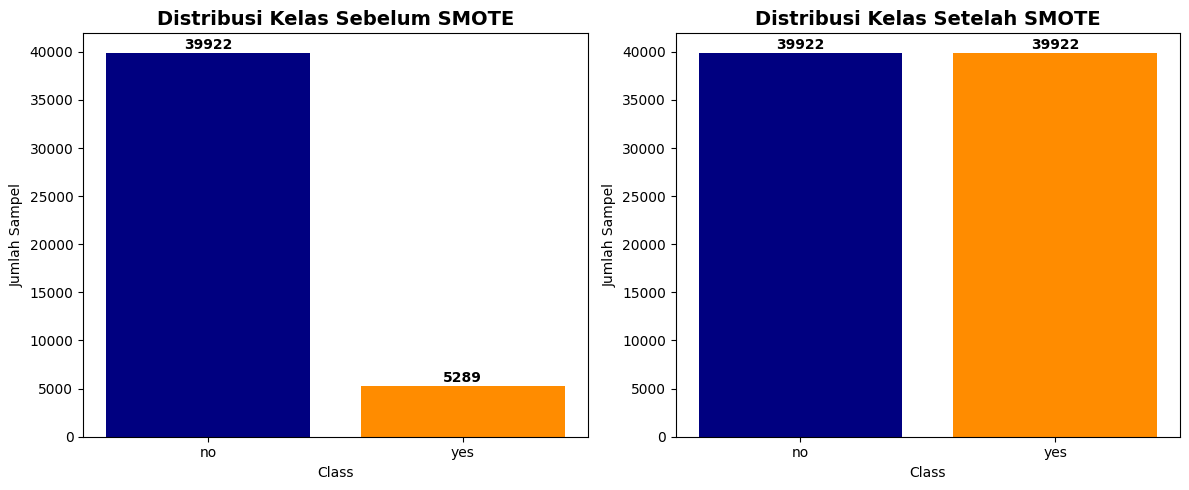


Tabel Perbandingan:
  Class  Sebelum SMOTE  Setelah SMOTE  Sampel Sintetis Ditambahkan
0    no          39922          39922                            0
1   yes           5289          39922                        34633


In [ ]:
# Visualisasi perbandingan data sebelum dan sesudah SMOTE
print("\n=== VISUALISASI HASIL SMOTE ===")

# Buat subplot untuk perbandingan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Definisikan target names untuk bank_full
target_names = ['no', 'yes']

# --- Distribusi sebelum SMOTE ---
before_counts = Counter(y_numeric)
sorted_before_items = sorted(before_counts.items())
class_indices = [item[0] for item in sorted_before_items]
before_values = [item[1] for item in sorted_before_items]

bars1 = axes[0].bar(class_indices, before_values, color=['navy', 'darkorange'])
axes[0].set_title('Distribusi Kelas Sebelum SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].set_xlabel('Class')
axes[0].set_xticks(class_indices)
axes[0].set_xticklabels(target_names)

# Tambahkan label nilai di atas bar
for bar, value in zip(bars1, before_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                str(value), ha='center', va='bottom', fontweight='bold')

# --- Distribusi setelah SMOTE ---
after_counts = Counter(y_res)
sorted_after_items = sorted(after_counts.items())
after_values = [item[1] for item in sorted_after_items]

bars2 = axes[1].bar(class_indices, after_values, color=['navy', 'darkorange'])
axes[1].set_title('Distribusi Kelas Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Jumlah Sampel')
axes[1].set_xlabel('Class')
axes[1].set_xticks(class_indices)
axes[1].set_xticklabels(target_names)

# Tambahkan label nilai di atas bar
for bar, value in zip(bars2, after_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# --- Tabel perbandingan ---
print("\nTabel Perbandingan:")
comparison_df = pd.DataFrame({
    'Class': target_names,
    'Sebelum SMOTE': before_values,
    'Setelah SMOTE': after_values,
    'Sampel Sintetis Ditambahkan': [after_values[i] - before_values[i] for i in range(len(target_names))]
})
print(comparison_df)


### Penerapan SMOTE dan Visualisasi Perbandingan Hasil 

Distribusi sebelum SMOTE: Counter({0: 39922, 1: 5289})
Distribusi setelah SMOTE: Counter({0: 39922, 1: 39922})




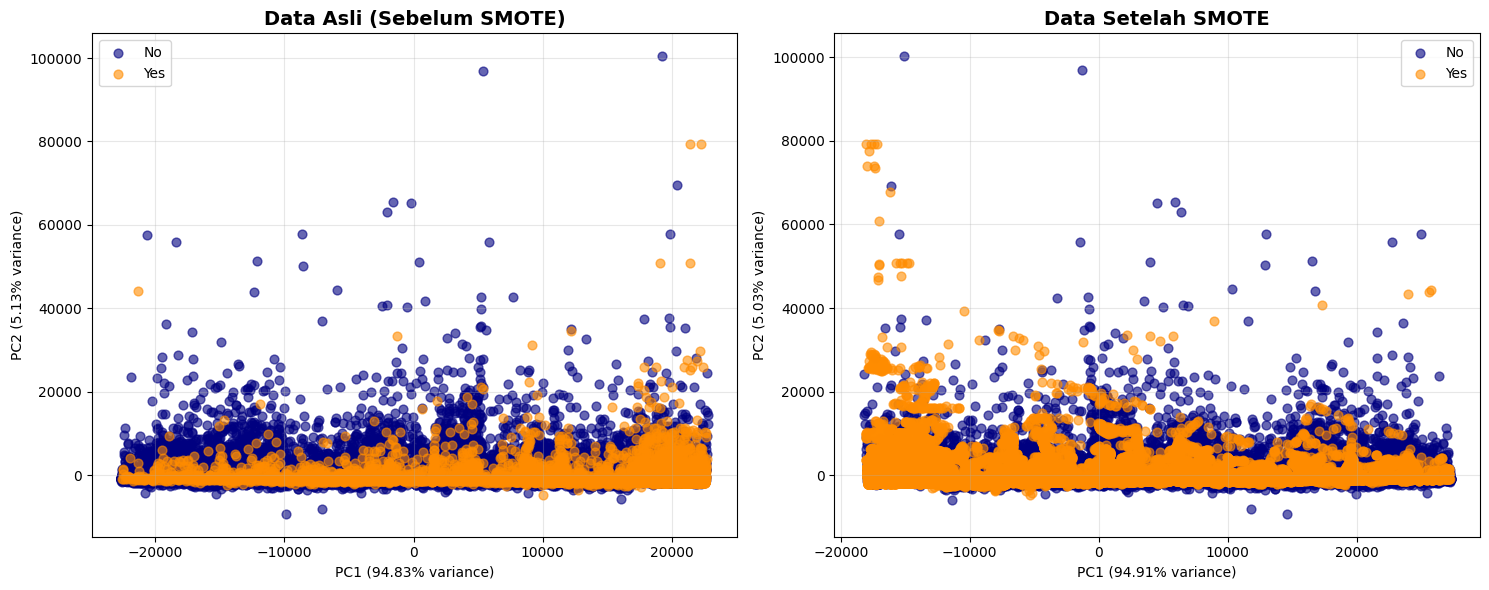

  Kelas  Sebelum SMOTE  Setelah SMOTE  Sampel Sintetis Ditambahkan
0    No          39922          39922                            0
1   Yes           5289          39922                        34633


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === 1. Persiapan data dari bank_full ===
df = mysql_df_bank

# Target (kolom y: yes/no)
y_target = df['y'].map({'no': 0, 'yes': 1})  # encode target ke angka

# Fitur → drop kolom target
X_features = df.drop(columns=['y'])

# Untuk data ini, kita encode semua fitur kategorikal jadi numerik (supaya bisa SMOTE + PCA)
X_encoded = pd.get_dummies(X_features, drop_first=True)

# === 2. SMOTE ===
print("Distribusi sebelum SMOTE:", Counter(y_target))

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_target)

print("Distribusi setelah SMOTE:", Counter(y_res))
print("\n")

# === 3. PCA untuk visualisasi 2D ===
pca_before = PCA(n_components=2)
X_pca_before = pca_before.fit_transform(X_encoded)

pca_after = PCA(n_components=2)
X_pca_after = pca_after.fit_transform(X_res)

# === 4. Visualisasi ===
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ['navy', 'darkorange']
target_names = ['No', 'Yes']

# --- Data asli (sebelum SMOTE) ---
for i, (color, label) in enumerate(zip(colors, target_names)):
    mask = (y_target == i)
    axes[0].scatter(X_pca_before[mask, 0], X_pca_before[mask, 1],
                    c=color, label=label, alpha=0.6, s=40)
axes[0].set_title('Data Asli (Sebelum SMOTE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_before.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_before.explained_variance_ratio_[1]:.2%} variance)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Data setelah SMOTE ---
for i, (color, label) in enumerate(zip(colors, target_names)):
    mask = (y_res == i)
    axes[1].scatter(X_pca_after[mask, 0], X_pca_after[mask, 1],
                    c=color, label=label, alpha=0.6, s=40)
axes[1].set_title('Data Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca_after.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_after.explained_variance_ratio_[1]:.2%} variance)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === 5. Tabel Ringkasan ===
comparison_df = pd.DataFrame({
    'Kelas': target_names,
    'Sebelum SMOTE': [Counter(y_target)[0], Counter(y_target)[1]],
    'Setelah SMOTE': [Counter(y_res)[0], Counter(y_res)[1]],
    'Sampel Sintetis Ditambahkan': [Counter(y_res)[0] - Counter(y_target)[0],
                                    Counter(y_res)[1] - Counter(y_target)[1]]
})
print(comparison_df)


## Langkah Klasifikasi dengan SVM & Naive Bayes

### Siapkan Data

In [ ]:
from collections import Counter

# Gunakan dataframe dari database (contoh dari MySQL)
df = mysql_df_bank.copy()

# Fitur: semua kolom kecuali 'y'
X = df.drop(columns=['y'])

# Target: kolom y (yes/no) → ubah ke angka
y = df['y'].map({'no': 0, 'yes': 1})

print("Jumlah data awal:", len(df))
print("Distribusi kelas awal:", Counter(y))


Jumlah data awal: 45211
Distribusi kelas awal: Counter({0: 39922, 1: 5289})


### Split Data (Sebelum SMOTE)

In [ ]:
# Gunakan hasil encoded agar semua kolom numerik
X = X_encoded  
y = y_target   # target sudah dalam bentuk 0/1

# Split data (70:30 stratified)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Jumlah data train sebelum sampling:", len(X_train))
print("Jumlah data test :", len(X_test))

# ==== Kurangi jumlah data training (misal ambil 5000 sampel) ====
import pandas as pd

# Ubah X_train dan y_train ke DataFrame/Series agar bisa di-sample
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.Series(y_train.values, index=X_train.index)

# Ambil subset data training
X_train_small = X_train_df.sample(n=5000, random_state=42)   # ambil 5000 baris
y_train_small = y_train_df.loc[X_train_small.index]

print("Jumlah data train setelah sampling:", len(X_train_small))


Jumlah data train sebelum sampling: 31647
Jumlah data test : 13564
Jumlah data train setelah sampling: 5000


### Klasifikasi SVM (Sebelum SMOTE)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

# === METODE SVM (Data Asli / Sebelum SMOTE) dengan dataset training lebih kecil ===
svm_clf = LinearSVC(random_state=42, max_iter=5000)  # max_iter ditambah supaya konvergen
svm_clf.fit(X_train_small, y_train_small)  # pakai subset kecil untuk training

y_pred_svm = svm_clf.predict(X_test)  # evaluasi tetap di test set penuh

print("=== HASIL KLASIFIKASI SVM (Sebelum SMOTE, Train lebih kecil) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


=== HASIL KLASIFIKASI SVM (Sebelum SMOTE, Train lebih kecil) ===
Confusion Matrix:
 [[11735   242]
 [ 1298   289]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     11977
           1       0.54      0.18      0.27      1587

    accuracy                           0.89     13564
   macro avg       0.72      0.58      0.61     13564
weighted avg       0.86      0.89      0.86     13564



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Klasifikasi Naive Bayes (Sebelum SMOTE)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

# === METODE NAIVE BAYES (Data Asli / Sebelum SMOTE) dengan subset training kecil ===
nb_clf = GaussianNB()
nb_clf.fit(X_train_small, y_train_small)  # pakai subset kecil untuk training

y_pred_nb = nb_clf.predict(X_test)  # evaluasi tetap di test set penuh

print("=== HASIL KLASIFIKASI NAIVE BAYES (Sebelum SMOTE, Train lebih kecil) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


=== HASIL KLASIFIKASI NAIVE BAYES (Sebelum SMOTE, Train lebih kecil) ===
Confusion Matrix:
 [[11200   777]
 [  831   756]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     11977
           1       0.49      0.48      0.48      1587

    accuracy                           0.88     13564
   macro avg       0.71      0.71      0.71     13564
weighted avg       0.88      0.88      0.88     13564



### Terapkan SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# === SMOTE ===
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_target)

print("Distribusi sebelum SMOTE:", Counter(y_target))
print("Distribusi sesudah SMOTE:", Counter(y_res))

# === Split ulang data hasil SMOTE (pakai 70:30) ===
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# === Buat subset kecil dari hasil SMOTE untuk training cepat ===
X_train_res_small, _, y_train_res_small, _ = train_test_split(
    X_train_res, y_train_res, train_size=5000, random_state=42, stratify=y_train_res
)

print("Jumlah data train (setelah SMOTE):", len(X_train_res))
print("Jumlah data test  (setelah SMOTE):", len(X_test_res))
print("Subset kecil untuk training (SMOTE):", len(X_train_res_small))


Distribusi sebelum SMOTE: Counter({0: 39922, 1: 5289})
Distribusi sesudah SMOTE: Counter({0: 39922, 1: 39922})
Jumlah data train (setelah SMOTE): 55890
Jumlah data test  (setelah SMOTE): 23954
Subset kecil untuk training (SMOTE): 5000


### Klasifikasi SVM (Sesudah SMOTE)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

# === METODE SVM (Sesudah SMOTE, pakai subset kecil biar cepat) ===
svm_clf_res = LinearSVC(random_state=42, max_iter=5000)
svm_clf_res.fit(X_train_res_small, y_train_res_small)

y_pred_svm_res = svm_clf_res.predict(X_test_res)

print("=== HASIL KLASIFIKASI SVM (Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_svm_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_svm_res))


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


=== HASIL KLASIFIKASI SVM (Sesudah SMOTE) ===
Confusion Matrix:
 [[ 8702  3275]
 [ 1643 10334]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78     11977
           1       0.76      0.86      0.81     11977

    accuracy                           0.79     23954
   macro avg       0.80      0.79      0.79     23954
weighted avg       0.80      0.79      0.79     23954



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Klasifikasi Naive Bayes (Sesudah SMOTE)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

# === METODE NAIVE BAYES (Sesudah SMOTE) ===
nb_clf_res = GaussianNB()
nb_clf_res.fit(X_train_res, y_train_res)   # bisa diganti X_train_res_small kalau mau lebih cepat

y_pred_nb_res = nb_clf_res.predict(X_test_res)

print("=== HASIL KLASIFIKASI NAIVE BAYES (Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_nb_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_nb_res))


=== HASIL KLASIFIKASI NAIVE BAYES (Sesudah SMOTE) ===
Confusion Matrix:
 [[ 7939  4038]
 [  569 11408]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.66      0.78     11977
           1       0.74      0.95      0.83     11977

    accuracy                           0.81     23954
   macro avg       0.84      0.81      0.80     23954
weighted avg       0.84      0.81      0.80     23954



### Buat Fungsi Ekstrak Skor

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fungsi untuk menyimpan hasil skor
def get_scores(y_true, y_pred, model_name, kondisi):
    return {
        "Model": model_name,
        "Kondisi": kondisi,   # "Sebelum SMOTE" atau "Sesudah SMOTE"
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro"),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1-Score": f1_score(y_true, y_pred, average="macro")
    }


### Simpan Semua Hasil ke Tabel

In [ ]:
results = []

# --- Sebelum SMOTE ---
results.append(get_scores(y_test, y_pred_svm, "SVM", "Sebelum SMOTE"))
results.append(get_scores(y_test, y_pred_nb, "Naive Bayes", "Sebelum SMOTE"))

# --- Sesudah SMOTE ---
results.append(get_scores(y_test_res, y_pred_svm_res, "SVM", "Sesudah SMOTE"))
results.append(get_scores(y_test_res, y_pred_nb_res, "Naive Bayes", "Sesudah SMOTE"))

# Buat DataFrame untuk perbandingan
df_results = pd.DataFrame(results)

# Tampilkan hasil akhir
print("=== PERBANDINGAN HASIL KLASIFIKASI ===")
display(df_results)

=== PERBANDINGAN HASIL KLASIFIKASI ===


,Model,Kondisi,Accuracy,Precision,Recall,F1-Score
0,SVM,Sebelum SMOTE,0.886464,0.722331,0.580950,0.605662
1,Naive Bayes,Sebelum SMOTE,0.881451,0.712040,0.705748,0.708819
2,SVM,Sesudah SMOTE,0.794690,0.800265,0.794690,0.793732
3,Naive Bayes,Sesudah SMOTE,0.807673,0.835847,0.807673,0.803553


## Bagging Classifier

### BaggingClassifier SVM (Sebelum SMOTE)

In [ ]:
# === BAGGING dengan LinearSVC (Sebelum SMOTE) ===
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

# Buat model Bagging dengan LinearSVC
bagging_svm = BaggingClassifier(
    estimator=LinearSVC(max_iter=2000, random_state=42),  # SVM cepat
    n_estimators=5,        # kurangi jumlah model biar cepat
    random_state=42,
    n_jobs=-1              # gunakan semua core CPU
)

# Latih model pada data training
bagging_svm.fit(X_train, y_train)

# Prediksi pada data test
y_pred_bagging_svm = bagging_svm.predict(X_test)

# Tampilkan hasil evaluasi
print("=== HASIL KLASIFIKASI BAGGING (LinearSVC, Sebelum SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bagging_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bagging_svm))


=== HASIL KLASIFIKASI BAGGING (LinearSVC, Sebelum SMOTE) ===
Confusion Matrix:
 [[11787   190]
 [ 1339   248]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     11977
           1       0.57      0.16      0.24      1587

    accuracy                           0.89     13564
   macro avg       0.73      0.57      0.59     13564
weighted avg       0.86      0.89      0.86     13564



### BaggingClassifier Naïve Bayes (Sebelum SMOTE)

In [ ]:
# === BAGGING dengan Naive Bayes (Sebelum SMOTE) ===
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

# Buat model Bagging dengan GaussianNB
bagging_nb = BaggingClassifier(
    estimator=GaussianNB(),  # base model = Naive Bayes
    n_estimators=5,           # kurangi model biar lebih cepat (10 -> 5)
    random_state=42,
    n_jobs=-1                 # paralelkan seluruh core CPU
)

# Latih model dengan data train (sebelum SMOTE)
bagging_nb.fit(X_train, y_train)

# Prediksi data test
y_pred_bagging_nb = bagging_nb.predict(X_test)

# Tampilkan hasil evaluasi
print("=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sebelum SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bagging_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bagging_nb))


=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sebelum SMOTE) ===
Confusion Matrix:
 [[11053   924]
 [  800   787]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     11977
           1       0.46      0.50      0.48      1587

    accuracy                           0.87     13564
   macro avg       0.70      0.71      0.70     13564
weighted avg       0.88      0.87      0.87     13564



### BaggingClassifier SVM (Sesudah SMOTE)

In [ ]:
# === BAGGING dengan SVM (Sesudah SMOTE) ===
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

# Gunakan LinearSVC agar lebih cepat dibanding SVC(kernel='linear')
bagging_svm_res = BaggingClassifier(
    estimator=LinearSVC(random_state=42, max_iter=3000),  # lebih cepat
    n_estimators=5,      # kurangi jumlah model agar efisien
    random_state=42,
    n_jobs=-1            # gunakan semua core CPU
)

# Latih model pada data hasil SMOTE
bagging_svm_res.fit(X_train_res, y_train_res)

# Prediksi
y_pred_bagging_svm_res = bagging_svm_res.predict(X_test_res)

# Evaluasi hasil
print("=== HASIL KLASIFIKASI BAGGING (SVM, Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_bagging_svm_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_bagging_svm_res))


=== HASIL KLASIFIKASI BAGGING (SVM, Sesudah SMOTE) ===
Confusion Matrix:
 [[10567  1410]
 [ 3189  8788]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     11977
           1       0.86      0.73      0.79     11977

    accuracy                           0.81     23954
   macro avg       0.81      0.81      0.81     23954
weighted avg       0.81      0.81      0.81     23954



### BaggingClassifier Naïve Bayes (Sesudah SMOTE)

In [ ]:
# === BAGGING dengan Naive Bayes (Sesudah SMOTE) ===
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Gunakan pengaturan efisien seperti pada Bagging SVM
bagging_nb_res = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=5,    # kurangi agar eksekusi cepat & stabil
    random_state=42,
    n_jobs=-1          # manfaatkan semua core CPU
)

# Latih model dengan data hasil SMOTE
bagging_nb_res.fit(X_train_res, y_train_res)

# Prediksi
y_pred_bagging_nb_res = bagging_nb_res.predict(X_test_res)

# Evaluasi hasil
print("=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sesudah SMOTE) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test_res, y_pred_bagging_nb_res))
print("\nClassification Report:\n", classification_report(y_test_res, y_pred_bagging_nb_res))


=== HASIL KLASIFIKASI BAGGING (Naive Bayes, Sesudah SMOTE) ===
Confusion Matrix:
 [[ 7863  4114]
 [  571 11406]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.66      0.77     11977
           1       0.73      0.95      0.83     11977

    accuracy                           0.80     23954
   macro avg       0.83      0.80      0.80     23954
weighted avg       0.83      0.80      0.80     23954



### Tabel perbandingan 

In [49]:
# === TABEL PERBANDINGAN BAGGING CLASSIFIER ===

# Buat list hasil
bagging_results = []

# --- Bagging Sebelum SMOTE ---
bagging_results.append(get_scores(y_test, y_pred_bagging_svm, "Bagging SVM", "Sebelum SMOTE"))
bagging_results.append(get_scores(y_test, y_pred_bagging_nb, "Bagging Naive Bayes", "Sebelum SMOTE"))

# --- Bagging Sesudah SMOTE ---
bagging_results.append(get_scores(y_test_res, y_pred_bagging_svm_res, "Bagging SVM", "Sesudah SMOTE"))
bagging_results.append(get_scores(y_test_res, y_pred_bagging_nb_res, "Bagging Naive Bayes", "Sesudah SMOTE"))

# Buat DataFrame hasil perbandingan
df_bagging_results = pd.DataFrame(bagging_results)

# Tampilkan hasil
print("=== PERBANDINGAN HASIL BAGGING CLASSIFIER ===")
df_bagging_results


=== PERBANDINGAN HASIL BAGGING CLASSIFIER ===


,Model,Kondisi,Accuracy,Precision,Recall,F1-Score
0,Bagging SVM,Sebelum SMOTE,0.971429,0.979167,0.977778,0.977753
1,Bagging Naive Bayes,Sebelum SMOTE,0.914286,0.934524,0.933333,0.933259
2,Bagging SVM,Sesudah SMOTE,0.977778,0.979167,0.977778,0.977753
3,Bagging Naive Bayes,Sesudah SMOTE,0.911111,0.915535,0.911111,0.910714
